# Modelflow methods reference 

The main text of this document presents a large range of `modelflow` features in the context of where they may be used.  This chapter reproduces much of that information but out of context.  It is not a full technical reference to `modelflow` that can be found [here,]() but it does attempt to put into place a handy reference to many of the commands that a `modelflow` user of the World Bank models would need.




## Preparing the python workspace for use with `modelflow`

To use `modelflow` with the World Bank models one has to import into your python sessions the `modelflow` and python package elements that will be used.

If running code on google colab you will need to execute this code first to load necessary dependencies into this environment.


In [1]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')

If you are running on your own computers you can skip that step (although it does not matter if you leave it there).

Assuming the ModelFlow library has been installed on your machine, the following imports set up your notebook so that you can run the cells in this notebook.



In [2]:
#%matplotlib notebook
%matplotlib inline

In [3]:
from modelclass import model 

In order to manipulate plots later on matplotlib.pyplot is also imported. 

In [4]:
import matplotlib.pyplot as plt # To manipulate plots 

In [5]:
# housekeeping for developement 
%load_ext autoreload   
%autoreload 2

## Useful Jupyter Notebook commands and features



### .widescreen() 

Instructs modelflow to take full advantage of the space available on the browser under which `Jupyter Notebook` is running.

In [6]:
model.widescreen() 

### .scroll_off() 

Disables the scrolling feaures of  Jupyter Notebook cells.

Ib when would you ever use this?


In [7]:
model.scroll_off()

## .modelload 
Load a pre-existing model, data and descriptions. 

In much of this document the example the Pakistan model is used to demonstrate features.  The below loads the Pakistan model, solves it, and instantiates a dataframe with the initial values included in the file that was loaded. 

A properly constituted `pcim` file like `pak.pcim` contains:

- Model equations
- Data
- Simulation options 
- Variable descriptions 

Below a typical use of `modelload` and an explanation of the options called and the outputs of the call to the `modelload()` method.

In [8]:
mpak,baseline = model.modelload('../models/pak.pcim',run=True,silent=True,keep='Baseline')

file read:  C:\mflow\Aug23\papers\mfbook\content\models\pak.pcim


Variables created and options used as they appear on the command line from right to left:

**mpak** <br> 
The *modelload* method processes the input file and creates a python `modelflow` object called mpak. 

'mpak' is an **instance**  of the  model object with which we will work.

**baseline**  <br> 
Is a Pandas dataframe containing the data that was loaded. 

**Options**
'../models/pak.pcim' the file to be loaded by `modelload`

**run=False**
The model is not simulated but a model object is created and initiated with the data that was contained in the model that generated the pcim file loaded. 

**run=True** 
Instructs `modelflow` to solvethe model with the data included in the loaded pcim file. 

The simulation timeframe  and options from the time the file was saved will be used unless overridden. 

Solving the model will create two dataframes within the mpak model object:

**mpak.basedf** and **mpak.lastdf** 

Each will contain a dataframe with the result of the simulation. 


**silent=True**
Suppresses the display of information about the progress of the model simulation.
**silent=False**
Information regarding the simulation will be displayed.

**keep='Baseline'** This saves the result of the initial simulation in the mpak.keep_solutions dictionary.

The content is the same as the baseline dataframe initiated by the modelload command and the .lastdf and .basedf dataframes that are part of the model object mpak but this dataframe is stored separately and used to facilitate comparisons of simulation results. 

## .modeldump()

Saves the current state of a model object as a PCIM file.

**outfile :** The name you wish to give the file, you must supply the pcim extension.

**Keep= True/False**  if True will also save any kept simulations (this can increase the size of the file substantially).



example: ```

In [13]:
mpak.modeldump(r'../models/test.pcim')

help(mpak.modeldump)

Help on method modeldump in module modelclass:

modeldump(outfile='', keep=False) method of modelclass.model instance
    Dumps a model and its lastdf to a json file
    
    if keep=True the model.keep_solutions will alse be dumped



## scenarios

The model object can be used to run scenarios.

Scenarios can be run by submitting to the model object a dataframe that contains data for all of the exogenous variables defined in the model. 

If the model is well formed and all exogenous data in the model is included in  the dataframe the model will return a solution dataframe with both endogenous and exogenous results for all variables in the model.



In [10]:
scenario_exo  =  baseline.upd("<2020 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 30")
scenario = mpak(scenario_exo,2020,2100,keep='Coal, Oil and Gastax : 30') # runs the simulation

Variables created and options used as they appear on the command line from right to left:

**scenario** <br> 
The simulation generates a dataframe containing simulation results that is arbitrarily assigned the name scenario above.

**mpak** 
The model object that is performing the simulation.  This was generated earlier with the modelload() call.

**scenario_exo**
This is a dataframe that contains the changed data that will be simulated. It was created with the preceding `upd()` method which overwrote the value for the carbon price of coal.

**2020,2100**
The dates over which to run the simulation.  This is equivalent to `start=2020,end=2030,`.  If, as here, options are placed in the order that a python method expects, the option name is not required. 

**keep='Coal, Oil and Gastax : 30'**
Adds and stores the scenario results (dataframe) to the `mpak.keep_solutions` dictionary for subsequent reference. It can be retrieved later using the "Coal, Oil and Gastax : 29" key assigned here.

**keep_variables** (optional) specifies which variables will be saved, wild card specifications are permitted.  If not specified all variables will be kept.


### .oldkwargs
The `oldkwargs` property of the model object is automatically set with each simulation storing the options that were active when it was executed.  Unless options are changed they are persistent between calls to a given model object. The `.oldkwargs` property of a model object  stores the  persistent parameters.

Currently, the persistent option values are:

In [12]:
mpak.oldkwargs

{'silent': 1, 'alfa': 0.7, 'ldumpvar': 0, 'keep': 'Coal, Oil and Gastax : 30'}

Persistent options may be reset (set to their defaults) by The user by setting the dictionary to the empty set. 
```
mpak.oldkwargs = {}
```

## dataframe modification 

## Results visualizations

Now we have two dataframes with results ```baseline``` and ```scenario```. These dataframes can be manipulated and visualized
with the tools provided by the **pandas** library and other like **Matplotlib** and **Plotly**. However to make things easy the first and
latest simulation result is also in the mpak object:

- **mpak.basedf**: Dataframe with the values for baseline
- **mpak.lastdf**: Dataframe with the values for alternative  

This means that .basedf and .lastdf will contain the same result after the first simulation. <br>
If new scenarios are simulated the data in .lastdf will then be replaced with the latest results.

These dataframes are used by a number of model instance methods as you will see later. 

The user can assign dataframes to both .basedf and .lastdf. This is useful for comparing simulations which are not the first and last. 

In [11]:
print(f'mpak.basedf: Dataframe: with {mpak.basedf.shape[0]} years and {mpak.basedf.shape[1]} variables')
print(f'mpak.lastdf: Dataframe: with {mpak.lastdf.shape[0]} years and {mpak.lastdf.shape[1]} variables')

mpak.basedf: Dataframe: with 121 years and 1291 variables
mpak.lastdf: Dataframe: with 121 years and 1291 variables


### .keep_solutions, A dictionary of dataframes with results

Create a dictionary of dataframes with .keep_solutions. Sometimes we want to be able to compare more than two scenarios. Using ```keep='some description'``` the dataframe with results can be saved into a dictionary with the description as key and the dataframe as value.  

In our example we have created two scenarios. A baseline and a scenario with the tax set to 29. So mpak.keep_solutions looks like this: 

In [12]:
print('mpak.keep_solutions contains:')
for key,value in mpak.keep_solutions.items(): 
    print(f'key = {key:25}|Dataframe: {value.shape[0]} years and {value.shape[1]} variables')

mpak.keep_solutions contains:
key = Baseline                 |Dataframe: 121 years and 1291 variables
key = Coal, Oil and Gastax : 29|Dataframe: 121 years and 1291 variables


Sometime it can be useful to reset the ```.keep_solutions```, so that a new set of solutions can be inspected. This is done by replacing it with an empty dictionary. Two methods can be used:  
>mpak.keep_solutions = {}

or in the simulation call: 
>mpak(,,keep='')

### More on manipulating keep_solution:
[Here](../howto/experiments/create_experiment.ipynb)

## .current_per, The time frame operations are performed on
Most operations on a model class instance operates on the current time frame. 
It is a subset of the row index of the dataframe which is simulated. 

In this case it is: 

In [14]:
mpak.current_per

Int64Index([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
            2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
            2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052,
            2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
            2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074,
            2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085,
            2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096,
            2097, 2098, 2099, 2100],
           dtype='int64')

The possible times in the dataframe is contained in the ```<dataframe>.index``` property. 

In [15]:
scenario.index  # the index of the dataframe

Int64Index([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
            ...
            2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100],
           dtype='int64', length=121)

### .smpl, Set time frame 
The time frame can be set like this:

In [16]:
mpak.smpl(2020,2025)
mpak.current_per

Int64Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int64')

### .set_smpl, Set timeframe for a local scope
For many operations it can be useful to apply the operations for a shorter time frame, but retain the global time frame after the operation. <br>
This can be done  with a ```with``` statement like this. 

In [17]:
print(f'Global time  before   {mpak.current_per}')
with mpak.set_smpl(2022,2023):
    print(f'Local time frame      {mpak.current_per}')
print(f'Unchanged global time {mpak.current_per}')

Global time  before   Int64Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int64')
Local time frame      Int64Index([2022, 2023], dtype='int64')
Unchanged global time Int64Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int64')


### .set_smpl_relative Set relative timeframe for a local scope
When creating a script it can be useful to set the time frame relative to the 
current time. 

Like this:

In [18]:
print(f'Global time  before   {mpak.current_per}')
with mpak.set_smpl_relative (-1,0):
    print(f'Local time frame      {mpak.current_per}')
print(f'Unchanged global time {mpak.current_per}')

Global time  before   Int64Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int64')
Local time frame      Int64Index([2019, 2020, 2021, 2022, 2023, 2024, 2025], dtype='int64')
Unchanged global time Int64Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int64')


(index-operator)=
## Using the index operator [ ] to select and visualize variables. 
The index operator [ ] can be used to select variables and then process the values for quick analysis. 
 
To select variables the method accept patterns which defines variable names. Wildcards: 
- ```\*``` matches everything
- ```?``` matches any single character
- ```\[seq]``` matches any character in seq
- ```\[!seq]``` matches any character not in seq



For more how wildcards can be used, the specification can be found here (https://docs.python.org/3/library/fnmatch.html)


In the following example we are selecting the results of mpak['PAKNYGDPMKTPKN']

This call will return a special class (called ```vis```). It implements a number 
of methods and properties which comes in handy for quick analyses. 


Several properties and methods can be chained. An example:  

In [19]:
with mpak.set_smpl(2020,2100):
    mpak['PAKNYGDPMKTPKN'].difpctlevel.mul100.rename().plot(colrow=1,
                title='Difference to baseline in percent',top=0.8);

But first some basic information


### model['#ENDO'] 

Use '#ENDO' to access all endogenous variables in your model instance. 

For the sake of space, the result is saved in the variable 'allendo' and not printed. 

In [20]:
allendo = mpak['#ENDO']
# allendo.show

### Access values in .lastdf and .basedf

To limit the output printed, we set the time frame to 2020 to 2023. 

In [21]:
mpak.smpl(2020,2023);

To access the values of 'PAKNYGDPMKTPKN' and 'PAKNECONPRVTKN' from the latest simulation a small widget is displayed. 

In [22]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'] 

To access the values of 'PAKNYGDPMKTPKN' and 'PAKNECONPRVTKN' from the base dataframe, specify .base

In [23]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].base.df 

,PAKNYGDPMKTPKN,PAKNECONPRVTKN
2020,2.670160e+07,2.332304e+07
2021,2.720258e+07,2.383172e+07
2022,2.780126e+07,2.439406e+07
2023,2.849982e+07,2.501286e+07



### .df  Pandas dataframe 

Sometime you need to perform additional operations on the values. Therefor the .df will return a dataframe with the selected variables. 


In [24]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].df

,PAKNYGDPMKTPKN,PAKNECONPRVTKN
2020,2.648318e+07,2.268967e+07
2021,2.723559e+07,2.331771e+07
2022,2.796332e+07,2.394832e+07
2023,2.869072e+07,2.455519e+07



### .show  as a html table with tooltips 

If you want the variable descriptions use this 


In [25]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].show

### .names Variable names

If you select variables using wildcards, then you can access the names that correspond to your query.



In [26]:
mpak['PAKNYGDP??????'].names

['PAKNYGDPDISCCN',
 'PAKNYGDPDISCKN',
 'PAKNYGDPFCSTCN',
 'PAKNYGDPFCSTKN',
 'PAKNYGDPFCSTXN',
 'PAKNYGDPMKTPCD',
 'PAKNYGDPMKTPCN',
 'PAKNYGDPMKTPKD',
 'PAKNYGDPMKTPKN',
 'PAKNYGDPMKTPXN',
 'PAKNYGDPPOTLKN']

### .frml The formulas 

Use .frml to access all the equations for the endogenous variables.  

In [27]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].frml

PAKNYGDPMKTPKN : FRML <> PAKNYGDPMKTPKN = PAKNECONPRVTKN+PAKNECONGOVTKN+PAKNEGDIFTOTKN+PAKNEGDISTKBKN+PAKNEEXPGNFSKN-PAKNEIMPGNFSKN+PAKNYGDPDISCKN+PAKADAP*PAKDISPREPKN $
PAKNECONPRVTKN : FRML <Z,EXO> PAKNECONPRVTKN = (PAKNECONPRVTKN(-1)*EXP(-PAKNECONPRVTKN_A+ (-0.2*(LOG(PAKNECONPRVTKN(-1))-LOG((PAKNYYWBTOTLCN(-1)*(1-PAKGGREVDRCTXN(-1)/100))/PAKNECONPRVTXN(-1)))+1*((LOG((PAKNYYWBTOTLCN*(1-PAKGGREVDRCTXN/100))/PAKNECONPRVTXN))-(LOG((PAKNYYWBTOTLCN(-1)*(1-PAKGGREVDRCTXN(-1)/100))/PAKNECONPRVTXN(-1))))+0.0303228629698929+0.0163839011059956*DURING_2010-0.3*(PAKFMLBLPOLYXN/100-((LOG(PAKNECONPRVTXN))-(LOG(PAKNECONPRVTXN(-1)))))) )) * (1-PAKNECONPRVTKN_D)+ PAKNECONPRVTKN_X*PAKNECONPRVTKN_D $


### .rename() Rename variables to descriptions

Use .rename() to assign variable descriptions as variable names. 

Handy when plotting! 

In [28]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].rename().df

,GDP Expenditure side at market prices,Household Consumption
2020,2.648318e+07,2.268967e+07
2021,2.723559e+07,2.331771e+07
2022,2.796332e+07,2.394832e+07
2023,2.869072e+07,2.455519e+07


### Transformations of solution results 

When the variables has been selected through the index operator a number of standard data transformations can be performed. 

|Transfomation|Meaning|expression 
| :--- | :--- | :----------------------------------------------:|
| pct | Growth rates | $\frac{this_t}{this_{t-1}} -1$ |
| dif |Difference in level| $l-b$ |                                           |
| difpct| Difference in growth rate | $\big[\frac{l_t}{l_{t-1}} - 1 \big] - \big[\frac{b_t}{b_{t-1}} - 1 \big] $ |
| difpctlevel |difference in level as a pct of baseline | $\frac{l_t-b_t}{b_t} $ |
| mul100 | multiply by 100 | ${this_t \times 100}$ |

- $this$ is the chained value. Default lastdf but if preceeded by .base the values from .basedf will be used 
- $b$ is the values from .basedf
- $l$ is the values from .lastdf 


### .dif Difference in level 

The 'dif' command displays the difference in levels of the latest and previous solutions.

$l-b$

where l is the variable from the .lastdf and b is the variable from .basedf.  

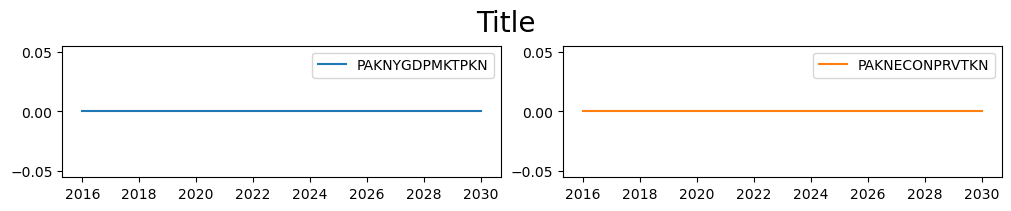

In [15]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].dif.plot()

### .pct  Growthrates 
Display growth rates

$\left(\cfrac{l_t}{l_{t-1}}-1\right )$

In [16]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].pct.plot();

### .difpct property difference in growthrate 
The difference in the growth rates  between the last and base dataframe.  

$\left( \cfrac{l_t}{l_{t-1}}-1 \right) - \left(\cfrac{b_t}{b_{t-1}}-1 \right)$

In [17]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct.plot() ; 

### .difpctlevel percent difference of  levels 

$\left( \cfrac{l_t-b_t}{b_{t}} \right) $

In [32]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpctlevel.plot();  

### mul100 multiply by 100 

multiply growth rate by 100. 

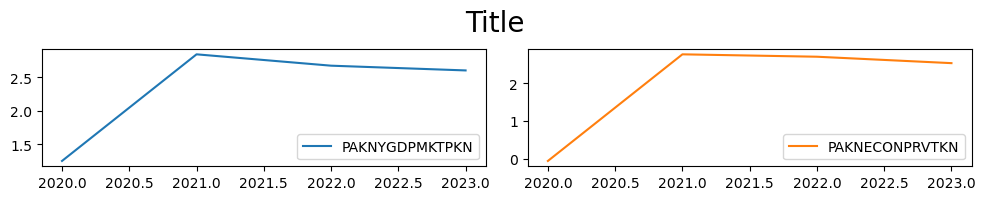

In [33]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].pct.mul100.plot() 

## .plot chart the selected and transformed variables
After the varaibles has been selected and transformed, they can  be plotted. The .plot() method plots the selected variables separately

In [34]:
mpak.smpl(2020,2100);

mpak['PAKNYGDP??????'].rename().plot();

### Options to plot() 

Common:<br>
- title (optional): title. Defaults to ''.
- colrow (TYPE, optional): Columns per row . Defaults to 2.
- sharey (TYPE, optional): Share y axis between plots. Defaults to False.
- top (TYPE, optional): Relative position of the title. Defaults to 0.90.
        
        
More excotic:<br>         
- splitchar (TYPE, optional): If the name should be split . Defaults to '__'.
- savefig (TYPE, optional): Save figure. Defaults to ''.
- xsize  (TYPE, optional): x size default to 10 
- ysize  (TYPE, optional): y size per row, defaults to 2
- ppos (optional): # of position to use if split. Defaults to -1.
- kind (TYPE, optional): Matplotlib kind . Defaults to 'line'.


In [35]:
mpak['PAKNYGDP??????'].difpct.mul100.rename().plot(title='GDP growth ',top = 0.92);

## Plotting inspiration


The following graph shows the components of GDP using the values of the baseline dataframe. 

In [36]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN PAKNEGDIFTOTKN'].\
difpctlevel.mul100.rename().\
plot(title='Components of GDP in pct of baseline',colrow=1,top=0.90,kind='bar') ;


###  Heatmaps

For some model types heatmaps can be helpful, and they come out of the box. This feature was developed for use by bank stress test models. 

In [37]:
with mpak.set_smpl(2020,2030):
    heatmap = mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].pct.rename().mul100.heat(title='Growth rates',annot=True,dec=1,size=(10,3))  


<a id=’With’></a>
### Violin and boxplots, 
Not obvious for macro models, but useful for stress test  models with many banks. 

In [38]:
with mpak.set_smpl(2020,2030): 
    mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct.box()  
    mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].difpct.violin()  


### Plot baseline vs alternative
A raw routine, only showing levels.
To make it really useful it should be expanded. 

In [39]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].plot_alt() ;


## .draw() Graphical presentation of relationships between variables

.draw() helps you understand the relationship between variables in your model better. 
 
The thickness the arrow reflect the attribution of the the upstream variable to the impact on the downstream variable. 

### .draw(up = level, down = level)


You can specify how many levels up and down you want in your graphical presentation (Needs more explanation).

In this example all variables that depend directly upon GDP and consumption as well as those that are determined by them, are displayed. This means one step upstream in the model logic and one step downstream. 

More on the how to visualize the logic structure [here](../howto/structure/Logical_structure.ipynb) 

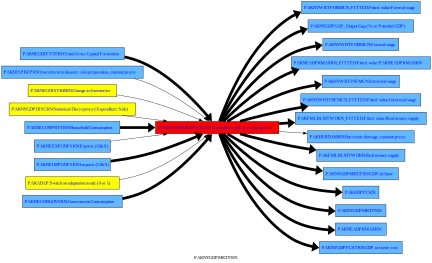

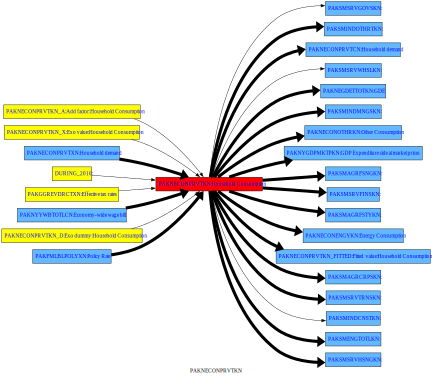

In [40]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].draw(up=1,down=1)  # diagram of all direct dependencies 

### .draw(filter =\<minimal impact>)

By specifying filter=  only links where the minimal impact is more than \<minimal impact> are show. In this case 20% 


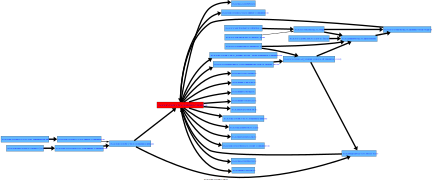

In [41]:
mpak['PAKNECONPRVTKN'].draw(up=3,down=1,filter=20)  



## dekomp() Attrribution of right hand side variables to change in result. 
For more information on attribution look [here](../howto/attribution/Attribution%20background.ipynb)

The dekomp command decomposes the contributions of the right hand side variables to the observed change in the left hand side variables. 

In [42]:
with mpak.set_smpl(2021,2025):
    mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].dekomp()  # frml attribution 


Formula        : FRML  <> PAKNYGDPMKTPKN = PAKNECONPRVTKN+PAKNECONGOVTKN+PAKNEGDIFTOTKN+PAKNEGDISTKBKN+PAKNEEXPGNFSKN-PAKNEIMPGNFSKN+PAKNYGDPDISCKN+PAKADAP*PAKDISPREPKN $ 

                       2021        2022        2023        2024        2025
Variable    lag                                                            
Base        0   27202580.71 27801259.41 28499818.71 29256735.74 30047560.47
Alternative 0   27235594.33 27963320.85 28690715.67 29445700.39 30238498.05
Difference  0      33013.62   162061.44   190896.96   188964.65   190937.58
Percent     0          0.12        0.58        0.67        0.65        0.64

 Contributions to differende for  PAKNYGDPMKTPKN
                         2021       2022       2023       2024       2025
Variable       lag                                                       
PAKNECONPRVTKN 0   -514010.77 -445732.98 -457677.02 -485936.67 -495257.60
PAKNECONGOVTKN 0    275618.47  268128.64  252327.22  239826.74  231709.68
PAKNEGDIFTOTKN 0    1207

## Bespoken plots using matplotlib  (or plotly -later) (should go to a separate plot book 

The predefined plots are not necessary created for presentation purpose. To create  bespoken plots the they can be 
constructed directly in python scripts. The two main libraries are matplotlib, plotly but any ther python plotting library can be used. Here is an example using matplotlib. 

## Plot four separate plots of multiple series in grid   

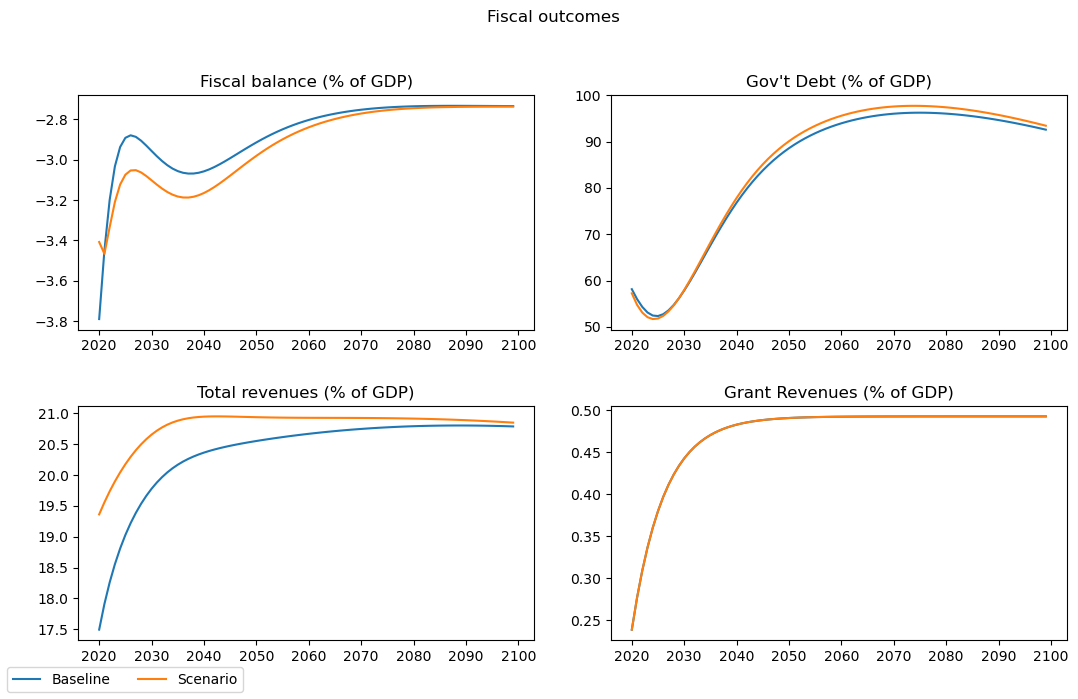

In [46]:
figure,axs= plt.subplots(2,2,figsize=(11, 7))
axs[0,0].plot(mpak.basedf.loc[2020:2099,'PAKGGBALOVRLCN_'],label='Baseline')
axs[0,0].plot(mpak.lastdf.loc[2020:2099,'PAKGGBALOVRLCN_'],label='Scenario')
#axs[0,0].legend()

axs[0,1].plot(mpak.basedf.loc[2020:2099,'PAKGGDBTTOTLCN_'],label='Baseline')
axs[0,1].plot(mpak.lastdf.loc[2020:2099,'PAKGGDBTTOTLCN_'],label='Scenario')

axs[1,0].plot(mpak.basedf.loc[2020:2099,'PAKGGREVTOTLCN']/mpak.basedf.loc[2020:2099,'PAKNYGDPMKTPCN']*100,label='Baseline')
axs[1,0].plot(mpak.lastdf.loc[2020:2099,'PAKGGREVTOTLCN']/mpak.lastdf.loc[2020:2099,'PAKNYGDPMKTPCN']*100,label='Scenario')

axs[1,1].plot(mpak.basedf.loc[2020:2099,'PAKGGREVGRNTCN']/mpak.basedf.loc[2020:2099,'PAKNYGDPMKTPCN']*100,label='Baseline')
axs[1,1].plot(mpak.lastdf.loc[2020:2099,'PAKGGREVGRNTCN']/mpak.lastdf.loc[2020:2099,'PAKNYGDPMKTPCN']*100,label='Scenario')
#axs2[4].plot(mpak.lastdf.loc[2000:2099,'PAKGGREVGRNTCN']/mpak.basedf.loc[2000:2099,'PAKNYGDPMKTPCN']*100,label='Scenario')

axs[0,0].title.set_text("Fiscal balance (% of GDP)")
axs[0,1].title.set_text("Gov't Debt (% of GDP)")
axs[1,0].title.set_text("Total revenues (% of GDP)")
axs[1,1].title.set_text("Grant Revenues (% of GDP)")
figure.suptitle("Fiscal outcomes")

plt.figlegend(['Baseline','Scenario'],loc='lower left',ncol=5)  
figure.tight_layout(pad=2.3) #Ensures legend does not overlap dates
figure